In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import seaborn as sns
import librosa
from librosa import display
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.utils import plot_model
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

import random

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

2025-06-17 09:06:22.721304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750131382.731800   30482 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750131382.735507   30482 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-17 09:06:22.746613: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Normalized features

In [2]:


# Define the path to your dataset
dataset_path = "/home/muzaffar/Desktop/Research/papers/02-paperhybrid-word-spken-paper(ablation)/10-words/original-data-3630"

# Initialize lists to hold features and labels
feature_list = []
label_list = []

# Define a function to normalize the mel spectrogram
def normalize_mel_spectrogram(mel_spectrogram):
    mel_spectrogram_db = librosa.power_to_db(S=mel_spectrogram, ref=1.0)
    return (mel_spectrogram_db - np.mean(mel_spectrogram_db)) / np.std(mel_spectrogram_db)

# Define a fixed size for padding (e.g., 128 time steps)
fixed_size = 32

# Update the feature extraction process
for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)

    for file in tqdm(os.listdir(class_path)):
        if not file.endswith('.wav'):
            continue

        audio_path = os.path.join(class_path, file)
        audio, sr = librosa.load(path=audio_path, sr=None)
        
        # Avoid using time_stretch unless intended
        # audio = librosa.effects.time_stretch(y=audio, rate=len(audio)/sr)

        mels = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=512)
        normalized_mels = normalize_mel_spectrogram(mels)

        # Pad or truncate to fixed size
        if normalized_mels.shape[1] < fixed_size:
            # Pad with zeros
            pad_width = fixed_size - normalized_mels.shape[1]
            padded_mels = np.pad(normalized_mels, ((0, 0), (0, pad_width)), mode='constant')
        else:
            # Truncate to fixed size
            padded_mels = normalized_mels[:, :fixed_size]

        feature_list.append(padded_mels.T)
        label_list.append(class_folder)

# Convert to NumPy arrays
features = np.array(feature_list)
labels = np.array(label_list)

print("Feature shape:", features.shape)
print("Label shape:", labels.shape)


100%|██████████| 364/364 [00:01<00:00, 344.92it/s]

Feature shape: (3630, 32, 128)
Label shape: (3630,)


In [3]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Set parameters for data splitting and training
TEST_SIZE = 0.2
RANDOM_STATE = 42  # For reproducibility

# Encode Labels (from strings to integers)
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(labels)

# One-hot encode the integer labels
encoded_labels = tf.one_hot(indices=integer_labels, depth=len(label_encoder.classes_))

from sklearn.model_selection import train_test_split

# Perform stratified split
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    encoded_labels.numpy(), 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    stratify=integer_labels  # Stratify ensures balanced splits for each class
)


print("Train, validation, and test data prepared successfully.")


Train, validation, and test data prepared successfully.


I0000 00:00:1750131394.371439   30482 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10252 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:0b:00.0, compute capability: 6.1


In [4]:
features[1].shape

(32, 128)

/home/muzaffar/anaconda3/envs/tf12/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



✅ Logistic Regression Accuracy: 0.6364

📊 Metrics for class 'Akh' (Logistic Regression):
Precision: 0.6579
Recall: 0.6944
F1-Score: 0.6757
Support: 72.0

📊 Metrics for class 'Zie' (Logistic Regression):
Precision: 0.5316
Recall: 0.5833
F1-Score: 0.5563
Support: 72.0

📊 Metrics for class 'Thrre' (Logistic Regression):
Precision: 0.5065
Recall: 0.5342
F1-Score: 0.5200
Support: 73.0

📊 Metrics for class 'Tsor' (Logistic Regression):
Precision: 0.5750
Recall: 0.6301
F1-Score: 0.6013
Support: 73.0

📊 Metrics for class 'Pancs' (Logistic Regression):
Precision: 0.7018
Recall: 0.5479
F1-Score: 0.6154
Support: 73.0

📊 Metrics for class 'Shae' (Logistic Regression):
Precision: 0.6087
Recall: 0.5833
F1-Score: 0.5957
Support: 72.0

📊 Metrics for class 'Sath' (Logistic Regression):
Precision: 0.7200
Recall: 0.7397
F1-Score: 0.7297
Support: 73.0

📊 Metrics for class 'Eahght' (Logistic Regression):
Precision: 0.7324
Recall: 0.7123
F1-Score: 0.7222
Support: 73.0

📊 Metrics for class 'Nav' (Logistic R

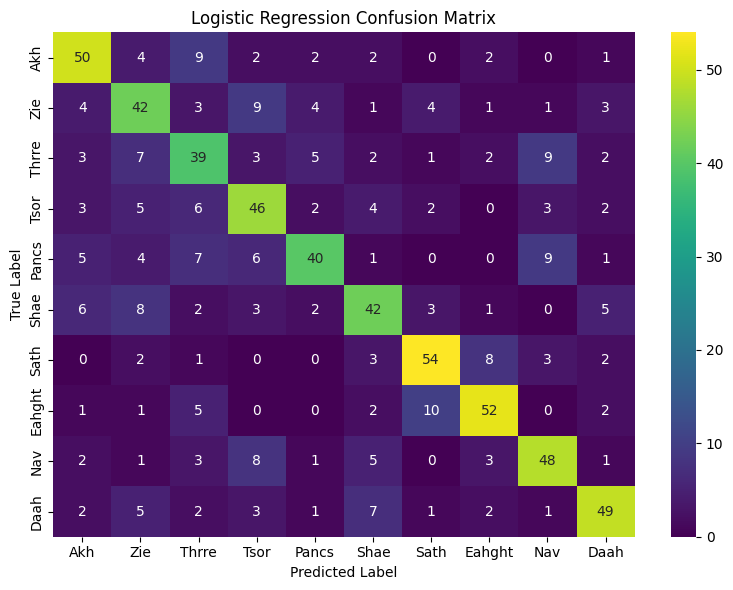

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Class names
custom_ticks = ['Akh', 'Zie', 'Thrre', 'Tsor', 'Pancs', 'Shae', 'Sath', 'Eahght', 'Nav', 'Daah']

# Step 1: Flatten Mel-spectrograms
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Step 2: Convert one-hot labels to integers
y_train_int = np.argmax(y_train, axis=1)
y_test_int = np.argmax(y_test, axis=1)

# Step 3: Train Logistic Regression
lr_model = LogisticRegression(
    solver='lbfgs',         # Solver for multinomial logistic regression
    multi_class='multinomial',
    max_iter=1000,          # Increase if convergence warning occurs
    random_state=42
)
lr_model.fit(X_train_flat, y_train_int)

# Step 4: Predict
y_pred_lr = lr_model.predict(X_test_flat)

# Step 5: Evaluation
accuracy_lr = accuracy_score(y_test_int, y_pred_lr)
print(f"\n✅ Logistic Regression Accuracy: {accuracy_lr:.4f}")

report_lr = classification_report(y_test_int, y_pred_lr, target_names=custom_ticks, output_dict=True)

# Step 6: Print class-wise metrics
for class_name in custom_ticks:
    print(f"\n📊 Metrics for class '{class_name}' (Logistic Regression):")
    print(f"Precision: {report_lr[class_name]['precision']:.4f}")
    print(f"Recall: {report_lr[class_name]['recall']:.4f}")
    print(f"F1-Score: {report_lr[class_name]['f1-score']:.4f}")
    print(f"Support: {report_lr[class_name]['support']}")

# Step 7: Confusion matrix
conf_matrix_lr = confusion_matrix(y_test_int, y_pred_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='viridis', xticklabels=custom_ticks, yticklabels=custom_ticks)
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()
